***Author: BV Pradeep*** 

Date: 19/09/2019

Third Week Assignment- Make Money with Machine Learning Course

References : 



1.   https://webcache.googleusercontent.com/search?q=cache:VTUxSLdK9zEJ:https://www.data-blogger.com/2017/06/15/fraud-detection-a-simple-machine-learning-approach/+&cd=4&hl=en&ct=clnk&gl=in
2.   https://stripe.com/radar/guide
3. https://www.kaggle.com/plasticgrammer/ieee-cis-fraud-detection-eda/notebook#Load-data
4. https://www.kaggle.com/tunguz/eda-with-python-datatable
5. https://github.com/mannybernabe/intro_fraud_detection/blob/master/Intro%20to%20Fraud%20Detection.ipynb
6. https://www.kaggle.com/kartikathale/fraud-detection-eda-basic-logistic-regression

7. Memory saving function: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage





In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Importing the neccessry librries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.3f}'.format

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import gc,os,sys
import re
from tqdm import tqdm

## Importing the csv file and reducing memory usage

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df



In [4]:
%%time
train_id = pd.read_csv('/gdrive/My Drive/Data/ieee-fraud-detection/train_identity.csv')
train_trn = pd.read_csv('/gdrive/My Drive/Data/ieee-fraud-detection/train_transaction.csv')
test_id = pd.read_csv('/gdrive/My Drive/Data/ieee-fraud-detection/test_identity.csv')
test_trn = pd.read_csv('/gdrive/My Drive/Data/ieee-fraud-detection/test_transaction.csv')

CPU times: user 1min 3s, sys: 5.08 s, total: 1min 8s
Wall time: 1min 9s


In [5]:
%%time
train_id = reduce_mem_usage(train_id)
train_trn = reduce_mem_usage(train_trn)
test_id = reduce_mem_usage(test_id)
test_trn = reduce_mem_usage(test_trn)

Memory usage of dataframe is 45.12 MB --> 25.86 MB (Decreased by 42.7%)
Memory usage of dataframe is 1775.15 MB --> 542.35 MB (Decreased by 69.4%)
Memory usage of dataframe is 44.39 MB --> 25.44 MB (Decreased by 42.7%)
Memory usage of dataframe is 1519.24 MB --> 472.59 MB (Decreased by 68.9%)
CPU times: user 3min, sys: 1.62 s, total: 3min 1s
Wall time: 3min 2s


## Merging the Datasets


In [6]:
print("train_id Shape:",train_id.shape,"Train_trn Shape:",train_trn.shape)
print("test_id Shape:",test_id.shape,"test_trn Shape:",test_trn.shape)

train_id Shape: (144233, 41) Train_trn Shape: (590540, 394)
test_id Shape: (141907, 41) test_trn Shape: (506691, 393)


In [0]:
train_merged = pd.merge(train_trn, train_id, on='TransactionID', how='left')

In [8]:
print("train_merged Shape:",train_merged.shape)

train_merged Shape: (590540, 434)


In [9]:
train_merged.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500,W,13926,nan,150.000,discover,142.000,credit,315.000,87.000,19.000,nan,NaN,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,2.000,0.000,1.000,1.000,14.000,nan,13.000,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.000,150.000,mastercard,102.000,credit,325.000,87.000,nan,nan,gmail.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.000,150.000,visa,166.000,debit,330.000,87.000,287.000,nan,outlook.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.000,150.000,mastercard,117.000,debit,476.000,87.000,nan,nan,yahoo.com,NaN,2.000,5.000,0.000,0.000,0.000,4.000,0.000,0.000,1.000,0.000,1.000,0.000,25.000,1.000,112.000,112.000,0.000,94.000,0.000,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.000,150.000,mastercard,102.000,credit,420.000,87.000,nan,nan,gmail.com,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,0.000,nan,nan,nan,nan,nan,nan,nan,nan,...,0.000,"70,787.000",nan,nan,nan,nan,nan,nan,nan,nan,100.000,NotFound,nan,-480.000,New,NotFound,166.000,nan,542.000,144.000,nan,nan,NaN,nan,nan,nan,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.000,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [10]:
train_merged_columns = list(train_merged.columns)
print("No of Coulmns in train_merged",len(train_merged_columns))

No of Coulmns in train_merged 434


In [0]:
test_merged = pd.merge(test_trn, test_id, on='TransactionID', how='left')

In [12]:
test_merged.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953,W,10409,111.000,150.000,visa,226.000,debit,170.000,87.000,1.000,nan,gmail.com,NaN,6.000,6.000,0.000,0.000,3.000,4.000,0.000,0.000,6.000,0.000,5.000,1.000,115.000,6.000,419.000,419.000,27.000,398.000,27.000,nan,nan,nan,nan,418.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000,W,4272,111.000,150.000,visa,226.000,debit,299.000,87.000,4.000,nan,aol.com,NaN,3.000,2.000,0.000,0.000,0.000,1.000,0.000,0.000,2.000,0.000,1.000,1.000,12.000,2.000,149.000,149.000,7.000,634.000,7.000,nan,nan,nan,nan,231.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000,W,4476,574.000,150.000,visa,226.000,debit,472.000,87.000,"2,636.000",nan,hotmail.com,NaN,2.000,2.000,0.000,0.000,0.000,5.000,0.000,0.000,4.000,0.000,2.000,0.000,22.000,2.000,137.000,137.000,10.000,97.000,10.000,nan,nan,nan,nan,136.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000,W,10989,360.000,150.000,visa,166.000,debit,205.000,87.000,17.000,nan,gmail.com,NaN,5.000,2.000,0.000,0.000,1.000,1.000,0.000,0.000,2.000,0.000,2.000,0.000,7.000,4.000,42.000,42.000,41.000,242.000,41.000,nan,nan,nan,nan,242.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.938,W,18018,452.000,150.000,mastercard,117.000,debit,264.000,87.000,6.000,nan,gmail.com,NaN,6.000,6.000,0.000,0.000,2.000,5.000,0.000,0.000,5.000,0.000,6.000,0.000,14.000,6.000,22.000,22.000,0.000,22.000,0.000,nan,nan,nan,nan,22.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
print("test_merged Shape:",test_merged.shape)

test_merged Shape: (506691, 433)


In [14]:
test_merged_columns = list(test_merged.columns)
print("No of Coulmns in train_merged",len(test_merged_columns))

No of Coulmns in train_merged 433


##Data Analysis

### Plotting the Fradulent transcation in Amounts

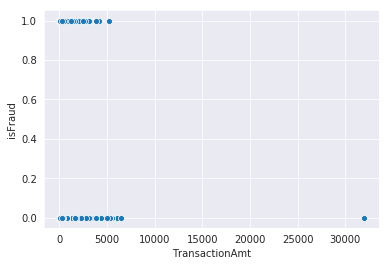

In [15]:
sns.scatterplot(x=train_merged['TransactionAmt'], y=train_merged['isFraud'])

####Plotting the Fraud transactions in the Merged Training Set


In [16]:
perc_fraud = len(train_merged[train_merged['isFraud']==1].index)*100/train_merged.shape[0]
print("Percentage of Fradaulent records in dataset {:.2f}".format(perc_fraud) )



Percentage of Fradaulent records in dataset 3.50


,0,1
isFraud,0.965,0.035


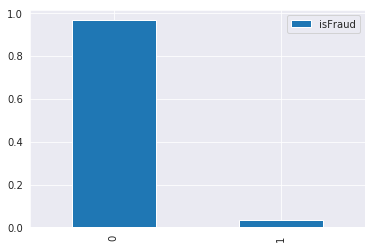

In [17]:
fc = train_merged['isFraud'].value_counts(normalize=True).to_frame()
fc.plot.bar()
fc.T

####Plotting Fault transactions on Different week days

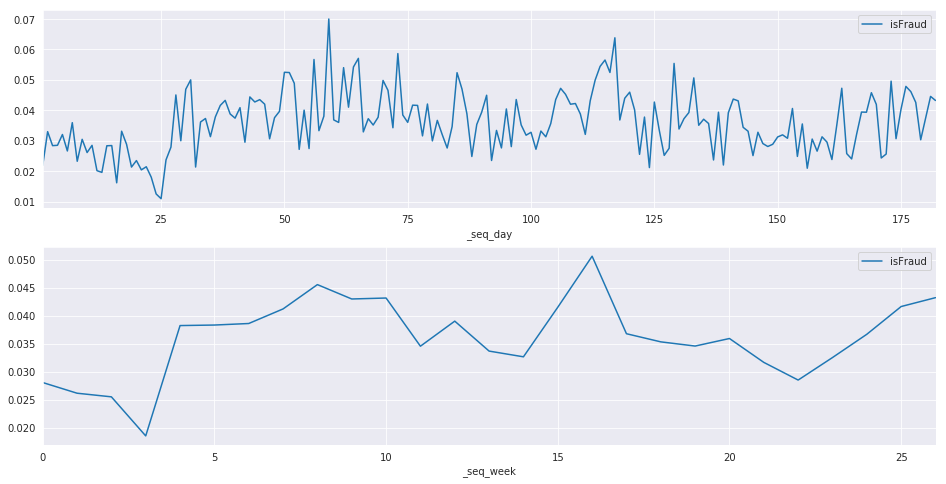

In [18]:
fig,ax = plt.subplots(2, 1, figsize=(16,8))

train_trn['_seq_day'] = train_trn['TransactionDT'] // (24*60*60)
train_trn['_seq_week'] = train_trn['_seq_day'] // 7
train_trn.groupby('_seq_day')['isFraud'].mean().to_frame().plot.line(ax=ax[0])
train_trn.groupby('_seq_week')['isFraud'].mean().to_frame().plot.line(ax=ax[1])

### Plotting Number of NULL Values in the Dataset

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

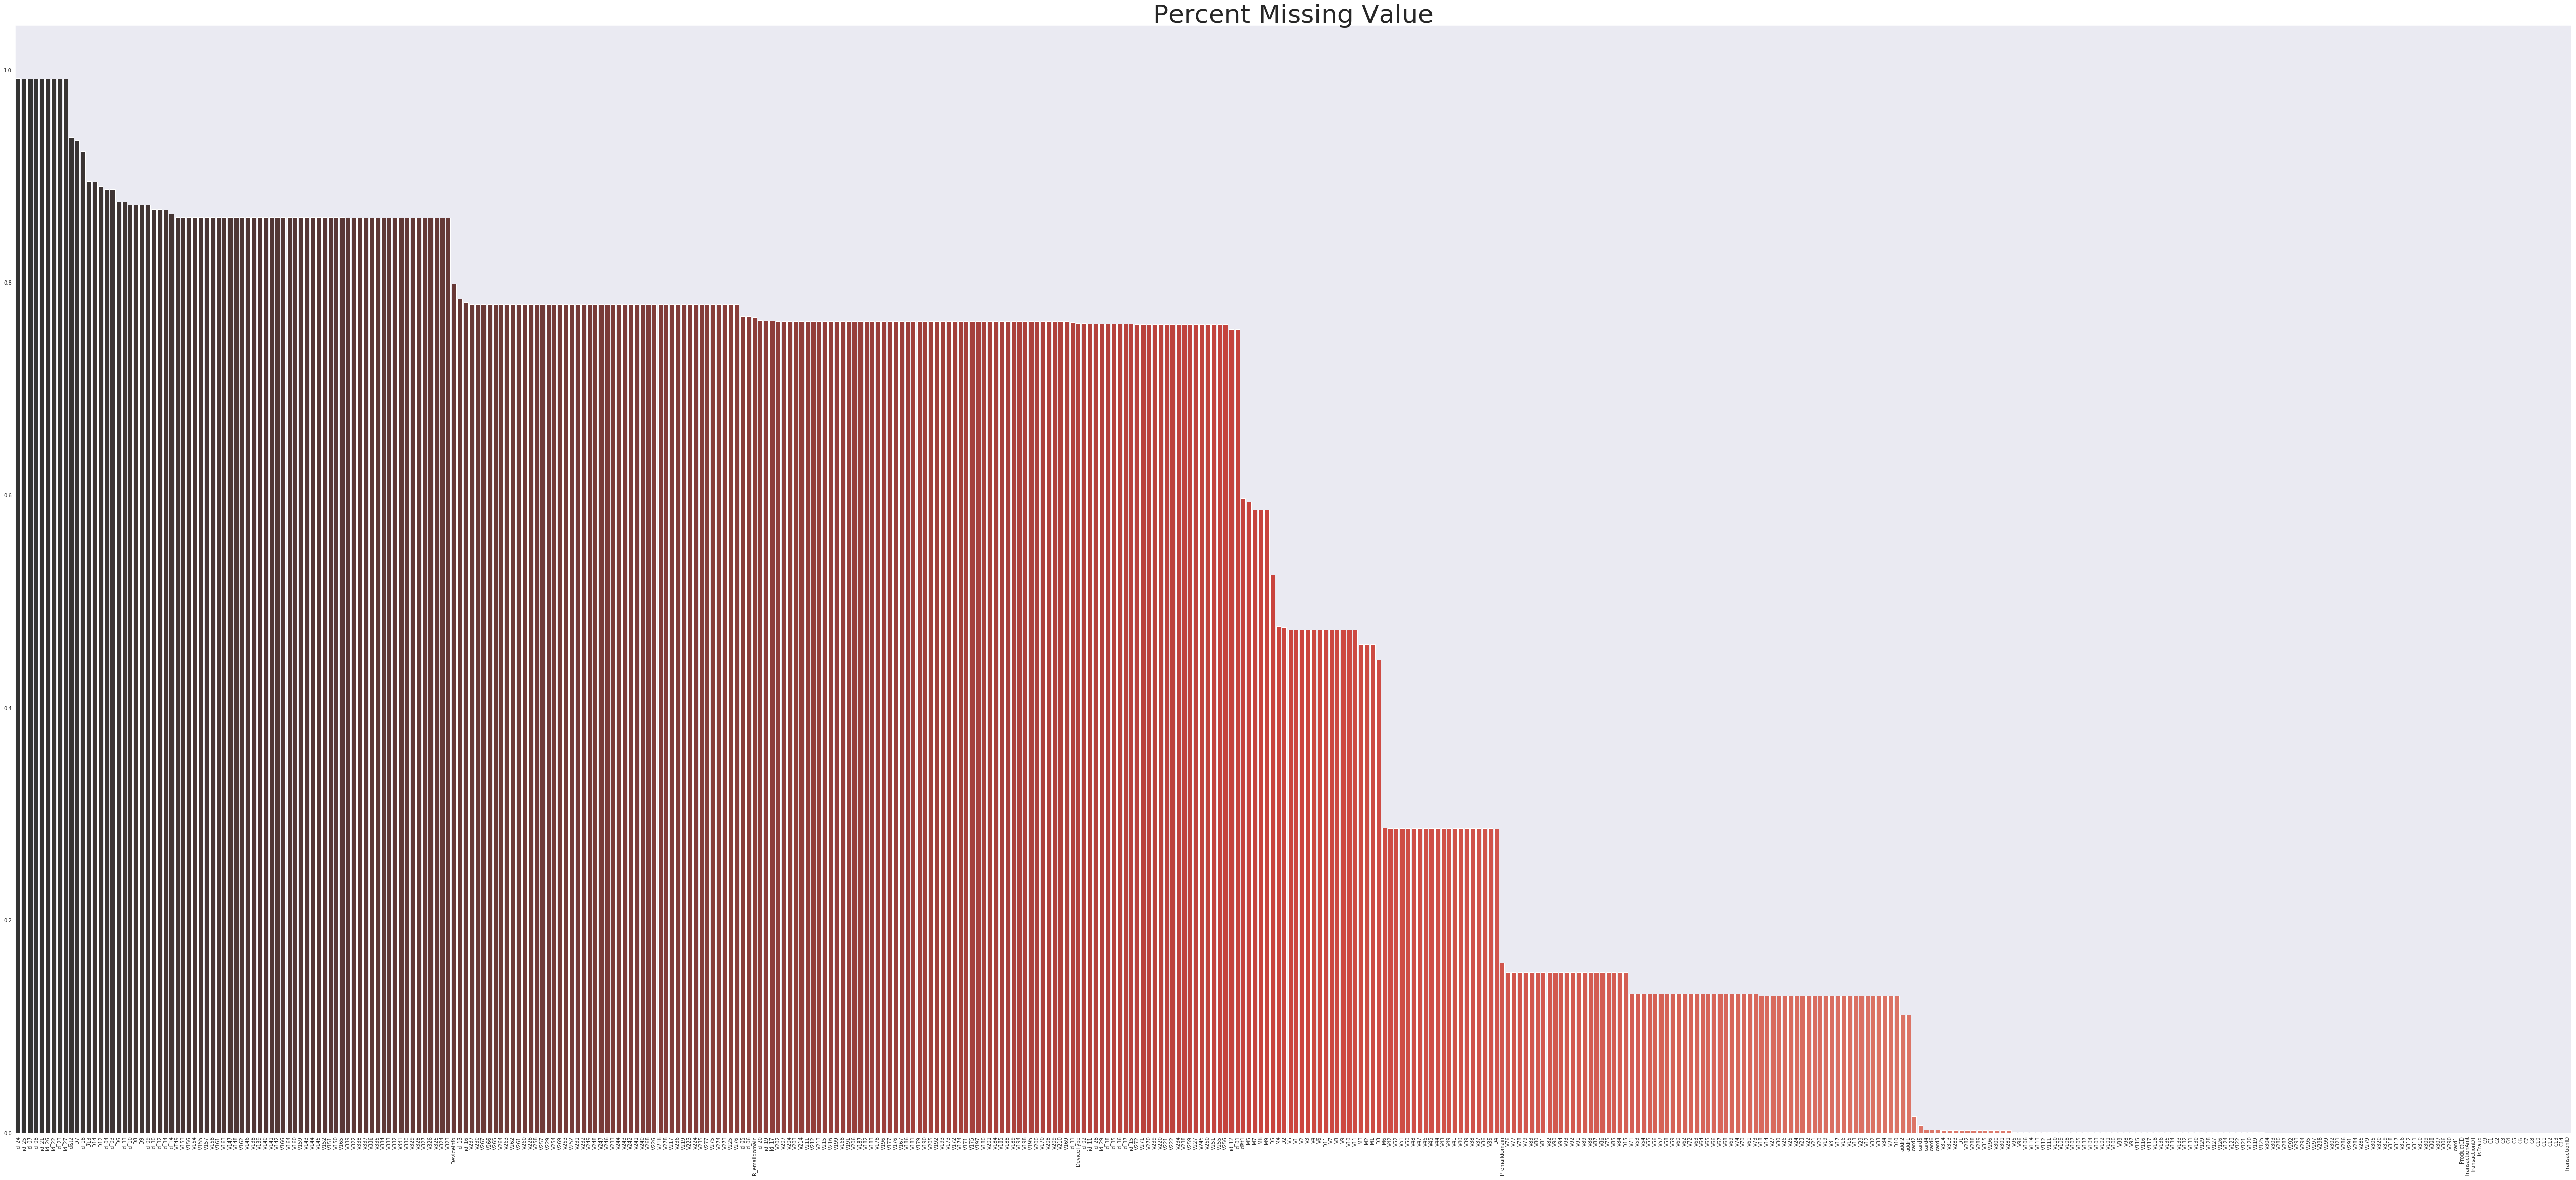

In [19]:
plt.figure(figsize=(90,40))
sns.barplot(y=train_merged.isnull().sum().sort_values(ascending=False)/len(train_merged),
            x=train_merged.isnull().sum().sort_values(ascending=False).index,
            palette="Reds_d")
plt.title("Percent Missing Value",size=50)
plt.xticks(rotation=90)



## Feature Selection

In [0]:
columns_def=pd.DataFrame({"na_count":train_merged.isnull().sum().sort_values(ascending=False)})

In [0]:
#Create column of percent columns, #higher is worst
columns_def["per"]=columns_def["na_count"]/len(train_merged)

In [22]:
#cycle throungh various limit for percent Na per column
range=[0.05, 0.10 ,0.15, 0.25, 0.40, 0.60, 0.75]

for i in range: 
    print (columns_def[columns_def["per"]<i].shape[0]/train_merged.shape[1])

0.25806451612903225
0.25806451612903225
0.3686635944700461
0.41935483870967744
0.46543778801843316
0.5207373271889401
0.5207373271889401


In [0]:
limit=0.10 #only columns w/ less 10% will remain
#Select final columns
columns_final=columns_def[columns_def["per"]<limit].index 

train_merged = train_merged[train_merged.columns.intersection(columns_final)]
test_merged = test_merged[test_merged.columns.intersection(columns_final)]

In [24]:
print("train_merged Shape:",train_merged.shape)

train_merged Shape: (590540, 112)


In [25]:
train_merged.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.500,W,13926,nan,150.000,discover,142.000,credit,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,2.000,0.000,1.000,1.000,14.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,117.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,117.000,0.000,0.000,0.000,0.000
1,2987001,0,86401,29.000,W,2755,404.000,150.000,mastercard,102.000,credit,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2987002,0,86469,59.000,W,4663,490.000,150.000,visa,166.000,debit,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2987003,0,86499,50.000,W,18132,567.000,150.000,mastercard,117.000,debit,2.000,5.000,0.000,0.000,0.000,4.000,0.000,0.000,1.000,0.000,1.000,0.000,25.000,1.000,112.000,1.000,48.000,28.000,0.000,10.000,4.000,1.000,38.000,24.000,0.000,0.000,0.000,1.000,1.000,...,0.000,0.000,0.000,10.000,0.000,4.000,0.000,0.000,1.000,1.000,1.000,1.000,38.000,24.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,50.000,"1,758.000",925.000,0.000,354.000,0.000,135.000,0.000,0.000,0.000,50.000,"1,404.000",790.000,0.000,0.000,0.000
4,2987004,0,86506,50.000,H,4497,514.000,150.000,mastercard,102.000,credit,1.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [26]:
train_merged_notohe_columns = list(train_merged.columns)
print("No of Coulmns in train_merged_not_ohe",len(train_merged_notohe_columns))

No of Coulmns in train_merged_not_ohe 112


In [0]:
dfdummies1 = pd.get_dummies(train_merged)

In [28]:
dfdummies1.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,2987000,0,86400,68.500,13926,nan,150.000,142.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,2.000,0.000,1.000,1.000,14.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,117.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,117.000,0.000,0.000,0.000,0.000,0,0,0,0,1,0,1,0,0,0,1,0,0
1,2987001,0,86401,29.000,2755,404.000,150.000,102.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,1,0,0,1,0,0,1,0,0
2,2987002,0,86469,59.000,4663,490.000,150.000,166.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,1,0,0,0,1,0,0,1,0
3,2987003,0,86499,50.000,18132,567.000,150.000,117.000,2.000,5.000,0.000,0.000,0.000,4.000,0.000,0.000,1.000,0.000,1.000,0.000,25.000,1.000,112.000,1.000,48.000,28.000,0.000,10.000,4.000,1.000,38.000,24.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,...,24.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,50.000,"1,758.000",925.000,0.000,354.000,0.000,135.000,0.000,0.000,0.000,50.000,"1,404.000",790.000,0.000,0.000,0.000,0,0,0,0,1,0,0,1,0,0,0,1,0
4,2987004,0,86506,50.000,4497,514.000,150.000,102.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,1,0,0,0,0,0,1,0,0,1,0,0


In [0]:
train_merged_ohe_columns = list(dfdummies1.columns) 

In [30]:
print("No of Coulmns in train_merged_ohe",len(train_merged_ohe_columns))

No of Coulmns in train_merged_ohe 122


In [0]:
train_merged  = dfdummies1

In [32]:
train_merged=train_merged._get_numeric_data()
train_merged=train_merged.dropna()

len(train_merged[train_merged["isFraud"]==1])/len(train_merged)*100

3.46278261170406

## Logistic Regression and Results

In [0]:
x=train_merged.drop(["isFraud"],axis=1)
y=train_merged["isFraud"]


In [0]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.80)

In [35]:
%%time
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 1.94 s, sys: 45.9 ms, total: 1.99 s
Wall time: 1.89 s


In [36]:
cr = classification_report(y_test,y_pred)
print("classification report:",cr)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


classification report:               precision    recall  f1-score   support

           0       0.97      1.00      0.98    446400
           1       0.00      0.00      0.00     16072

    accuracy                           0.97    462472
   macro avg       0.48      0.50      0.49    462472
weighted avg       0.93      0.97      0.95    462472



Confusion Matrix: [[446400      0]
 [ 16072      0]]


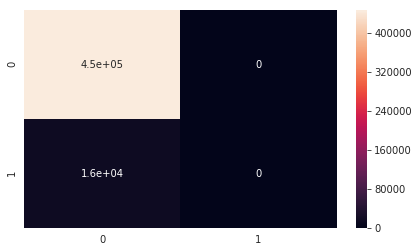

In [37]:
cm = metrics.confusion_matrix(y_test,y_pred)
print("Confusion Matrix:",cm)

plt.subplots(figsize=(7,4))
sns.heatmap(cm, annot=True)
plt.show()

In [38]:
acc = metrics.accuracy_score(y_test,y_pred)
print("Accuracy:",acc)

Accuracy: 0.9652476258022107


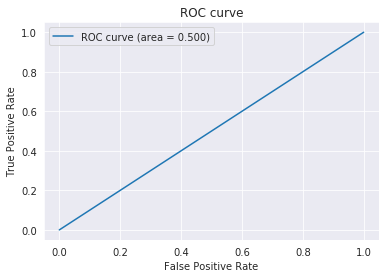

In [39]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)